# Examples 4.1-3

From Parameter Estimation and Inverse Problems, 3rd edition, 2018    
by R. Aster, B. Borchers, C. Thurber

## Implemented in Python by:
* Nima Nooshiri [@nimanzik](https://github.com/nimanzik)

---

In [1]:
%reset -f

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as nla
from scipy.interpolate import interp1d
from scipy.sparse.linalg import lsqr

from peiplib.lcurve import corner_maxcurv, tikh_svd
from peiplib.plot import get_cbar_axes, picard

In [3]:
plt.style.use('ggplot')
plt.style.use('./data/peiplib.mplstyle')

## Example 4.1

We revisit the severely ill-posed Shaw problem with $m=n=20$ intervals.

In [4]:
# Load in the Shaw problem data
data = np.load('./data/shaw20.npz')
G = data['G']
dspike = data['dspike']
dspiken = data['dspiken']
theta = data['theta']

# Add random noise to data
noise = 1.0e-6   # noise standard deviation
rng = np.random.default_rng()   # Random-number generator
dspiken = dspike + noise * rng.standard_normal(dspike.size)

### L-curve criterion

First, we calculate and plot the L-curve, and find its corner:

In [5]:
# Calculate the SVD
U, s, VT = nla.svd(G)
V = np.transpose(VT)

# Calculate the L-curve
rhos, etas, alphas = tikh_svd(U, s, dspiken, 1000)

# Estimate the L-curve corner in log-log space
rho_corner, eta_corner, alpha_tikh = corner_maxcurv(rhos, etas, alphas)

print(f'alpha from the L-curve is: {alpha_tikh:.2e}\n')

alpha from the L-curve is: 6.40e-06



Now, we calculate the spike solution corresponding to the L-curve corner:

In [6]:
n_data, n_model = G.shape
a = G.T @ G + (alpha_tikh**2) * np.identity(n_model, dtype=np.float64)
b = G.T @ dspiken
m_tikh = nla.solve(a, b)

and obtain the residual norm using the L-curve solution:

In [7]:
r_spike = nla.norm((G @ m_tikh) - dspiken)
print(
    f'Residual norm for L-curve solution using '
    f'Tikhonov regularisation: {r_spike:.2e}\n')

Residual norm for L-curve solution using Tikhonov regularisation: 2.92e-06



Now, we can plot the L-curve and add the corner marker:

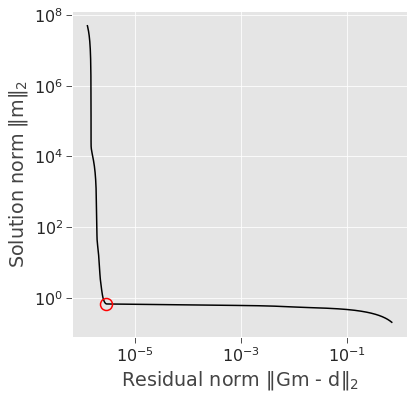

In [8]:
fig, ax = plt.subplots(1, 1)
ax.loglog(rhos, etas, 'k')
ax.loglog(rho_corner, eta_corner, 'ro', mfc='None', ms=12)
ax.set(
    xlabel=r'Residual norm $\Vert$Gm - d$\Vert_{2}$',
    ylabel=r'Solution norm $\Vert$m$\Vert_{2}$');

and plot the L-curve predicted model:

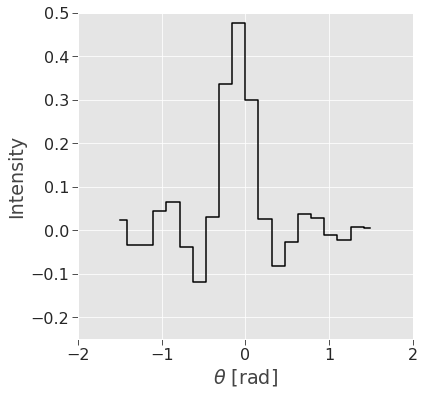

In [9]:
fig, ax = plt.subplots(1, 1)
ax.step(theta, m_tikh, 'k', where='mid')
ax.set(
    xlabel=r'$\theta$ [rad]', ylabel='Intensity',
    xlim=(-2, 2), ylim=(-0.25, 0.5));

### Discrepancy principle

Now we use the discrepancy principle to get a second solution.   
Below, we find the regularization value `alpha_disc` for `rho=discrep` by interpolation of the L-curve.

In [10]:
discrep = np.sqrt(20.0) * noise
f_interp = interp1d(rhos, alphas)
alpha_disc = f_interp(discrep)

print(f'alpha from the discrepancy principle is: {alpha_disc:.2e}\n')

alpha from the discrepancy principle is: 4.23e-05



and find the model and residual using the regularisation parameter obtained from discrepency principle:

In [11]:
m_disc = lsqr(G, dspiken, damp=alpha_disc)[0]
r_spike_disc = nla.norm((G @ m_disc) - dspiken)

print(
    f'Residual norm for L-curve solution using '
    f'Tikhonov regularisation: {r_spike_disc:.2e}\n')

Residual norm for L-curve solution using Tikhonov regularisation: 4.47e-06



Below is the plot of the discrepancy principle predicted model:

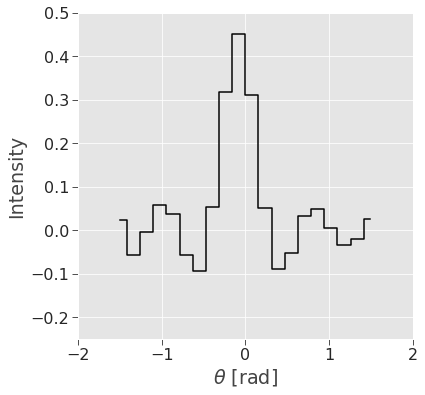

In [12]:
fig, ax = plt.subplots(1, 1)
ax.step(theta, m_disc, 'k', where='mid')
ax.set(
    xlabel=r'$\theta$ [rad]', ylabel='Intensity',
    xlim=(-2, 2), ylim=(-0.25, 0.5));

We can also produce the Picard plot:

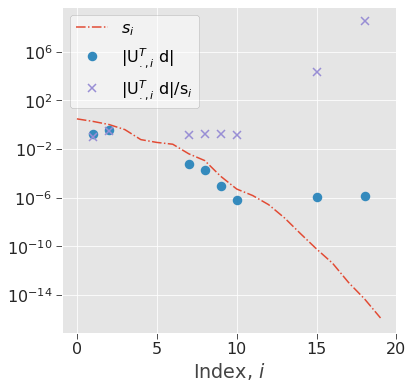

In [13]:
fig, ax = plt.subplots(1, 1)
picard(U, s, dspiken, ax)

---
### Example 4.2

In this step, we examine the resolution using a _noise-free_ spike test for `alpha_tikh`:

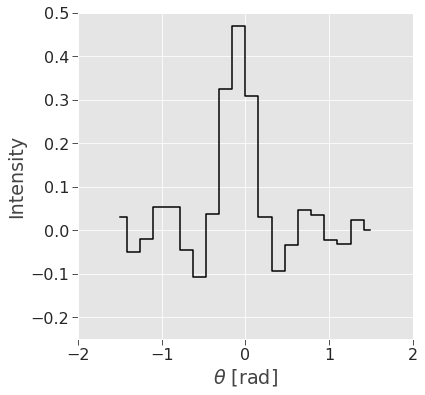

In [14]:
spikemod_tikh = lsqr(G, dspike, damp=alpha_tikh)[0]

# Plot the noise-free spike model for the L-curve
fig, ax = plt.subplots(1, 1)
ax.step(theta, spikemod_tikh, 'k', where='mid')
ax.set(
    xlabel=r'$\theta$ [rad]', ylabel='Intensity',
    xlim=(-2, 2), ylim=(-0.25, 0.5));

Now, we examine the resolution using a _noise-free_ spike test for `alpha_disc`:

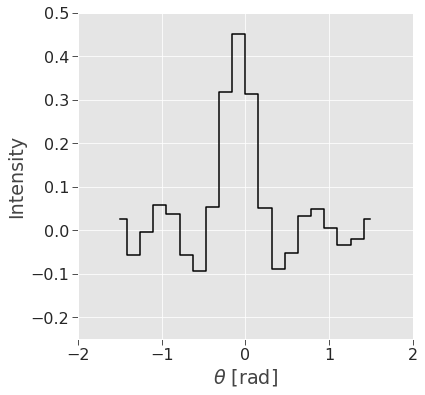

In [15]:
spikemod_disc = lsqr(G, dspike, damp=alpha_disc)[0]

# Plot the noise-free spike model for the discrepancy principle
fig, ax = plt.subplots(1, 1)
ax.step(theta, spikemod_disc, 'k', where='mid')
ax.set(
    xlabel=r'$\theta$ [rad]', ylabel='Intensity',
    xlim=(-2, 2), ylim=(-0.25, 0.5));

We can compute and display the resolution matrix for `alpha_disc`:

Diagonal resolution elements:
 [0.90812857 0.48878543 0.44854913 0.38953372 0.42116697 0.40945267
 0.42828977 0.43846725 0.44478564 0.45071588 0.45072382 0.4447762
 0.43846656 0.4283273  0.40937481 0.42122641 0.38952249 0.44855624
 0.48876627 0.9081382 ] 



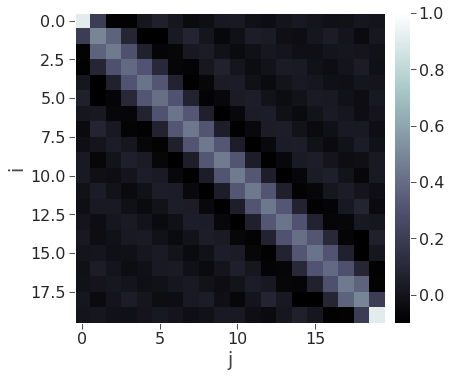

In [16]:
n_data, n_model = G.shape
dummy = G.T @ G + (alpha_disc**2) * np.identity(n_model, dtype=np.float64)
Ghash = nla.inv(dummy) @ G.T
Rm_disc = Ghash @ G

print('Diagonal resolution elements:\n', np.diag(Rm_disc), '\n')

# Plot the resolution matrix
fig, ax = plt.subplots(1, 1)
cimg = ax.imshow(Rm_disc, vmin=-0.1, vmax=1.0, cmap='bone')
cax = get_cbar_axes(ax)
cbar = plt.colorbar(cimg, cax=cax)
ax.set(xlabel='j', ylabel='i')
ax.grid(False)

---
### Example 4.3

In this step, we calculate the covariance of the discrepancy principle solution:

In [17]:
dummy = np.dot(Ghash, (noise**2) * np.identity(n_model, dtype=np.float64))
covmat_disc = dummy @ Ghash.T
conf95 = 1.96 * np.sqrt(np.diag(covmat_disc))

Plot of the discrepancy principle solution with error bars vs. reality:

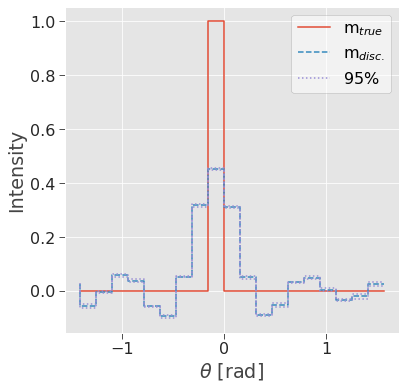

In [18]:
spike = np.zeros(n_model, dtype=np.float64)
spike[9] = 1.0

dtheta = theta[1] - theta[0]
theta2 = theta + (dtheta / 2)

fig, ax = plt.subplots(1, 1)
ax.plot(theta2, spike, drawstyle='steps', label=r'm$_{true}$')
ax.plot(theta2, m_disc, '--', drawstyle='steps', label=r'm$_{disc.}$')

dum = ax.plot(theta2, m_disc + conf95, ':', drawstyle='steps', label=r'95$\%$')
color = plt.get(dum[0], 'color')
ax.plot(theta2, m_disc - conf95, ':', color=color, drawstyle='steps')

ax.set(xlabel=r'$\theta$ [rad]', ylabel='Intensity')
ax.legend();